In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from datetime import datetime
import numpy as np
import warnings
import ml_metrics as metrics
from sklearn.metrics import r2_score
from datetime import datetime,timedelta
warnings.filterwarnings("ignore")

# Начальные данные 

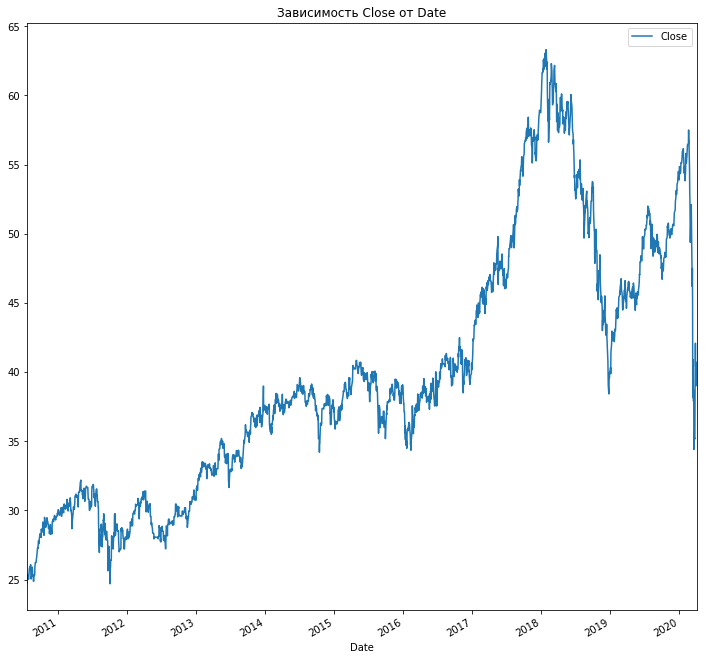

In [22]:
path1 = './data/AADR.csv'
df = pd.read_csv(path1)
predict_column = "Close"
df.Date = pd.to_datetime(df.Date)
fig, ax = plt.subplots(ncols=1, nrows = 1, figsize= (12,12))
ax.set_title(f'Зависимость {predict_column} от Date')
df.plot(x = "Date", y =predict_column , ax = ax)
plt.show()

По графику можно установить, что временной ряд имеет пять скачков

In [23]:
idx_one_model = datetime(2017,1,1)
idx_two_model = datetime(2018,1,1)
idx_three_model = datetime(2019,1,1)
idx_four_model = datetime(2020,1,1)

In [24]:
tsclose = df.Close
tsclose.index = df.Date
# tsclose = tsclose.resample('W',how='mean')


count    2442.000000
mean       39.765782
std         9.163881
min        24.700001
25%        31.672500
50%        38.230000
75%        46.169998
max        63.310001
Name: Close, dtype: float64

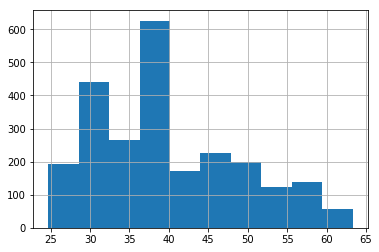

In [25]:
itog = tsclose.describe()
tsclose.hist()
itog

Проверка на нормальное распределние 

In [26]:
row = ['JB', 'p-value', 'skew', 'kertosis']
jb_test = sm.stats.jarque_bera(tsclose)
a = np.vstack([jb_test])
itog = SimpleTable(a,row)
print(itog)

        JB                p-value               skew             kertosis     
------------------------------------------------------------------------------
171.70225838131398 5.191924008964137e-38 0.5938680311340309 2.4739063493530873
------------------------------------------------------------------------------


# Определение порядка интеграции 

Тестом Дикки-Фуллера

In [27]:
test = sm.tsa.adfuller(tsclose)
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -1.7431774631564063
p-value: 0.40901457482921716
Critical values: {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}
есть единичные корни, ряд не стационарен


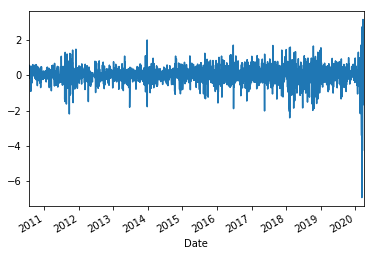

In [28]:
tsclose_diff1 = tsclose.diff(periods=1).dropna()
tsclose_diff1.plot()
plt.show()

In [29]:
test = sm.tsa.adfuller(tsclose_diff1)
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -18.525888942775424
p-value: 2.10595446710592e-30
Critical values: {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}
единичных корней нет, ряд стационарен


Проверка на независимость от времени мат ожидания

In [30]:
size = tsclose_diff1.shape[0]
m = tsclose_diff1.index[size//2+1]
r1 = sm.stats.DescrStatsW(tsclose_diff1[m:])
r2 = sm.stats.DescrStatsW(tsclose_diff1[:m])
print(f'p-value: {sm.stats.CompareMeans(r1,r2).ttest_ind()[1]}')


p-value: 0.499197618763913


Порядок интеграции d = 1

# Построение модели

In [31]:
tstemp = tsclose_diff1.apply(abs)
min_mae = tstemp.min()
max_mae = tstemp.max()
permissible_mae = (max_mae-min_mae)/2


Выбор p,q при помощи acf and pacf

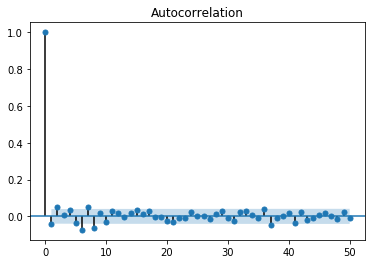

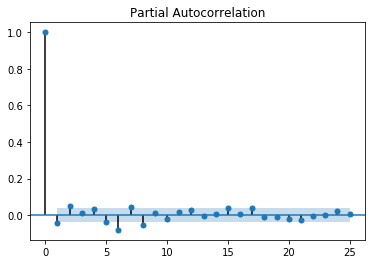

In [36]:
_ = sm.graphics.tsa.plot_acf(tsclose_diff1.values.squeeze(),lags=50)
_ =sm.graphics.tsa.plot_pacf(tsclose_diff1,lags=25)

Поиск максимальной возможной длины предсказания

In [33]:
idx_split = 2*tsclose.shape[0]//3 + 1

model = sm.tsa.ARIMA(tsclose[:idx_split],order = (1,1,1))
model_fit = model.fit(disp=0)

X_train = tsclose[:-10]
X_test = tsclose[-10:]
history = [x for x in X_train]

len_pred = 0
idx_test = 0
mae_result = 0
mse_result = 0
r2_result = 0
while True:

    idx_test = 0
    predictions = []
    while idx_test < X_test.shape[0]:
#         print(idx_test)
        model = sm.tsa.ARIMA(history,order = (1,1,1))
        model_fit = model.fit(disp=0, start_params = model_fit.params)
        start = len(history)
        end = start + len_pred
        pred = model_fit.predict(start = start ,end = end, typ='levels' )
        
        predictions.extend(pred)
        history.extend(X_test[idx_test:idx_test+len_pred+1])
        idx_test +=1 + len_pred
    r2_error = r2_score(predictions[:X_test.shape[0]],X_test)
    mae_error = metrics.mae(predictions[:X_test.shape[0]],X_test)
    mse_error = metrics.mse(predictions[:X_test.shape[0]],X_test)
    
    print(f'Len: {len_pred+1} | R2: {r2_error} | MAE: {mae_error} | MSE: {mse_error}')
    
    if mae_error > permissible_mae or r2_error <= 0:
        break
    else:
        mse_result = mse_error
        mae_result = mae_error
        r2_result = r2_error
        len_pred +=1
    
print(f'Допустимая длина предсказания {len_pred}')
print(f'R2: {r2_result} | MAE: {mae_result} | MSE: {mse_result}')
LEN_PREDICTION = len_pred

Len: 1 | R2: 0.683875056478572 | MAE: 1.2491238100992432 | MSE: 2.5450947752249053
Len: 2 | R2: -0.16460072548895188 | MAE: 2.1779935692424433 | MSE: 6.255077620601768
Допустимая длина предсказания 1
R2: 0.683875056478572 | MAE: 1.2491238100992432 | MSE: 2.5450947752249053


Построим модель после последнего скачка (используются значения коэфтцентов полученные на предыдущем этапе)

In [43]:
model_four = sm.tsa.ARIMA(tsclose[idx_four_model:],order=(1,1,1))
model_four_fit = model_four.fit(disp=0, start_params = model_fit.params)
model_four_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                   62
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -114.980
Method:                       css-mle   S.D. of innovations              1.535
Date:                Sun, 12 Apr 2020   AIC                            237.960
Time:                        03:29:43   BIC                            246.468
Sample:                             1   HQIC                           241.300
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2691      0.116     -2.314      0.024      -0.497      -0.041
ar.L1.D.Close     0.9565      0.050     19.212      0.000       0.859       1.054
ma.L1.D.Close    -1.0000      0.037    -26.834      0.000      -1.073      -0.927
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0454           +0.0000j            1.0454            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Проверка на независимость ошибок и Нормальность

In [63]:
q_test = sm.tsa.stattools.acf(model_four_fit.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

,Q-stat,p-value
0,0.165252,0.684367
1,1.861986,0.394162
2,2.757170,0.430599
3,3.421985,0.489839
4,3.652234,0.600488
5,7.198272,0.302900
6,8.345356,0.303128
7,11.938467,0.153971
8,11.940218,0.216701
9,12.126774,0.276662


# Анализ полученной модели

In [54]:
class TSResult:
    def __init__(self,ts,predictions):
        self.ts = ts
        self.predictions = predictions
    def plot(self, ax):
        for pred in self.predictions:
            ax = plt.plot(pred, color = 'red',label='Predict')
        ax = plt.plot(self.ts,color='grey')
        
    
def calc_predictions(history,X_test,params):
    model = sm.tsa.ARIMA(history, order = (1,1,1))
    model_fit = model.fit(disp=0,start_params = params)
    predictions = []
    for x_test in X_test:
        model = sm.tsa.ARIMA(history,order = (1,1,1))
        model_fit = model.fit(disp=0, start_params=model_fit.params )
        p = len(history)
        pred = model_fit.predict(start=p,end=p,typ='levels')
        predictions.extend(pred)
        history.append(x_test)
    predictions = pd.Series(predictions,index=X_test.index)
    return predictions
    

Не распличенная модель

In [56]:
idx_split = 2*tsclose.shape[0]//3 + 1
i_split = tsclose.shape[0]//2 + 1 
X_train = tsclose[:i_split]
X_test = tsclose[i_split:]
history = [x for x in X_train]
params = model_fit.params
predictions = calc_predictions(history,X_test,params) 


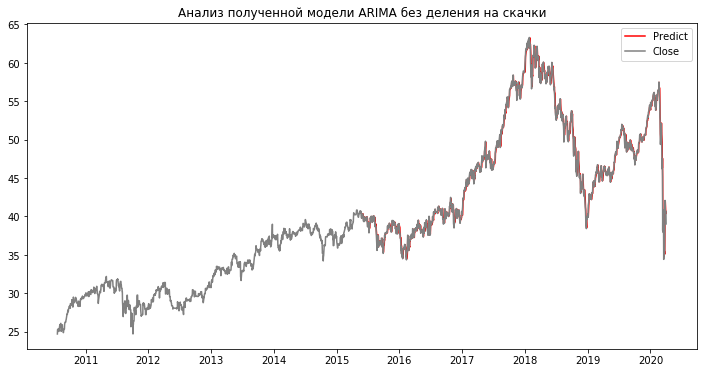

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ts = TSResult(tsclose,[predictions])
ts.plot(ax=ax)
ax.set_title('Анализ полученной модели ARIMA без деления на скачки')
plt.legend()
plt.show()  

# Прогнозирование

In [35]:
start_predict = tsclose[idx_four_model:].shape[0]
pred = model_four_fit.predict(start = start_predict, end=start_predict+LEN_PREDICTION,typ='levels')
last_date = tsclose.index[-1]
index_pred = [last_date + timedelta(days=i) for i in range(pred.shape[0])]
pred.index=index_pred
pred

2020-04-01    38.839085
2020-04-02    38.644772
dtype: float64

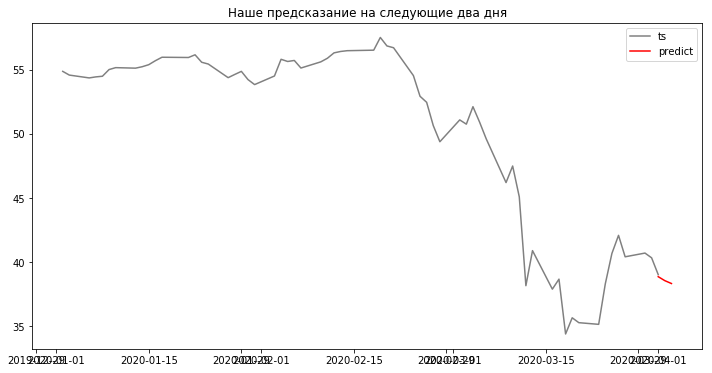

In [65]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_title('Наше предсказание на следующие два дня')
ax = plt.plot(tsclose[idx_four_model:],color='grey',label='ts')
ax = plt.plot(pred, color='red',label='predict')
plt.legend()
plt.show()